#Vehicle Detection pipeline - sliding windows, applying classifier and video generator

This is the part 3 of pipeline. The part 1 is the data exploration, part 2 is the classifier training



In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


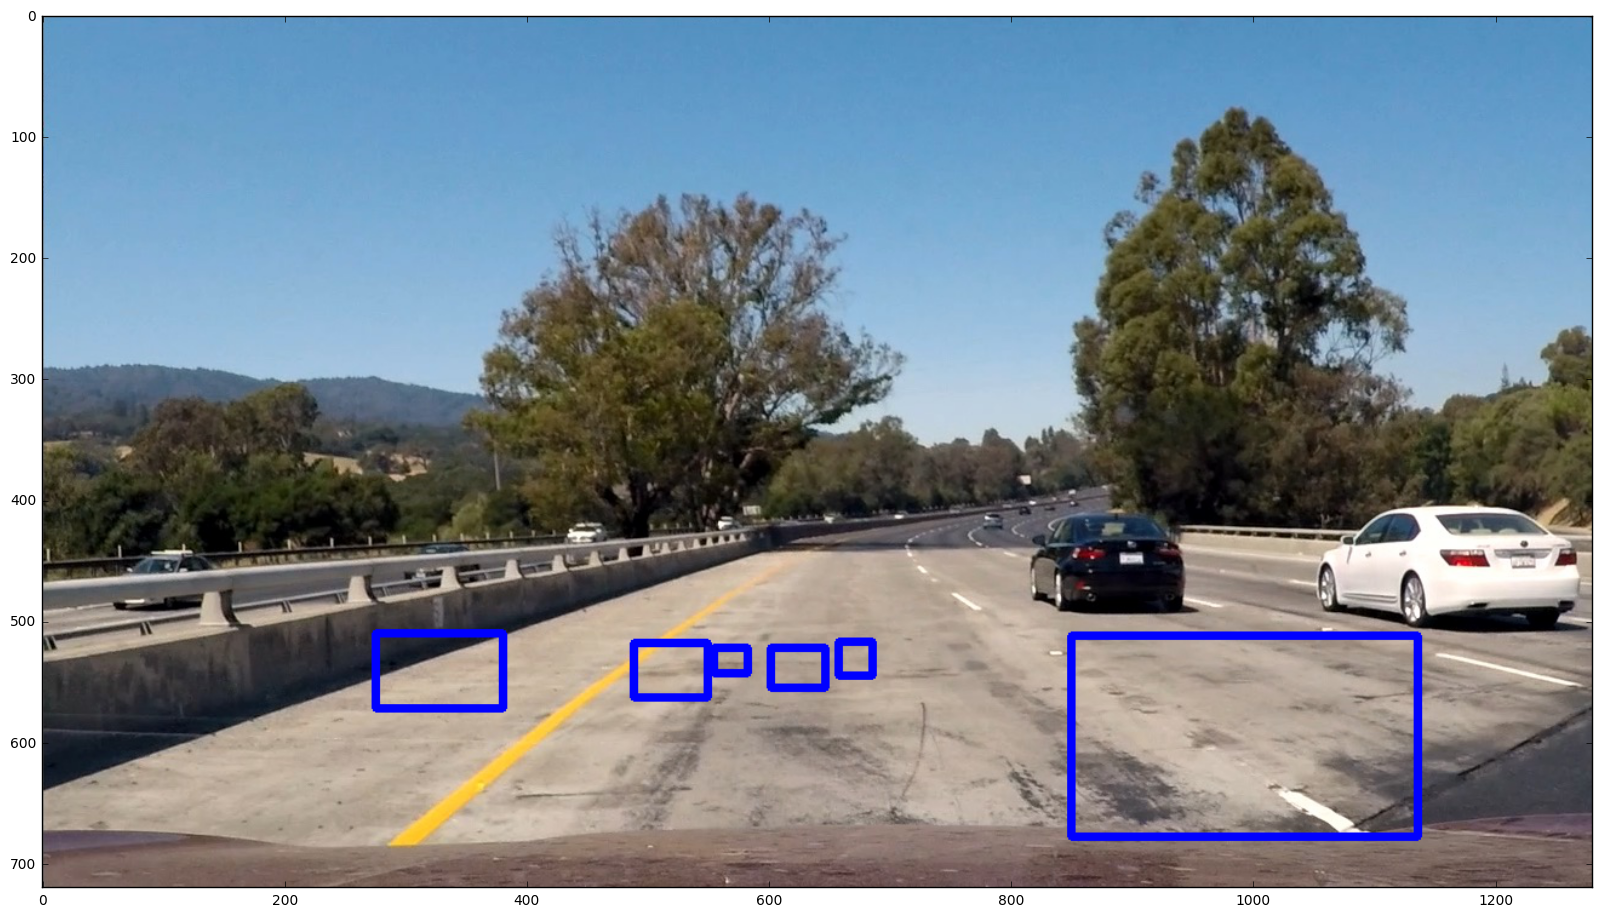

In [3]:

%matplotlib inline
image = mpimg.imread('test_images/test1.jpg')

#Box drawing
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for b in bboxes:
        cv2.rectangle(draw_img, b[0],b[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]


result = draw_boxes(image, bboxes)

plt.figure(figsize=(20,20))
plt.imshow(result)

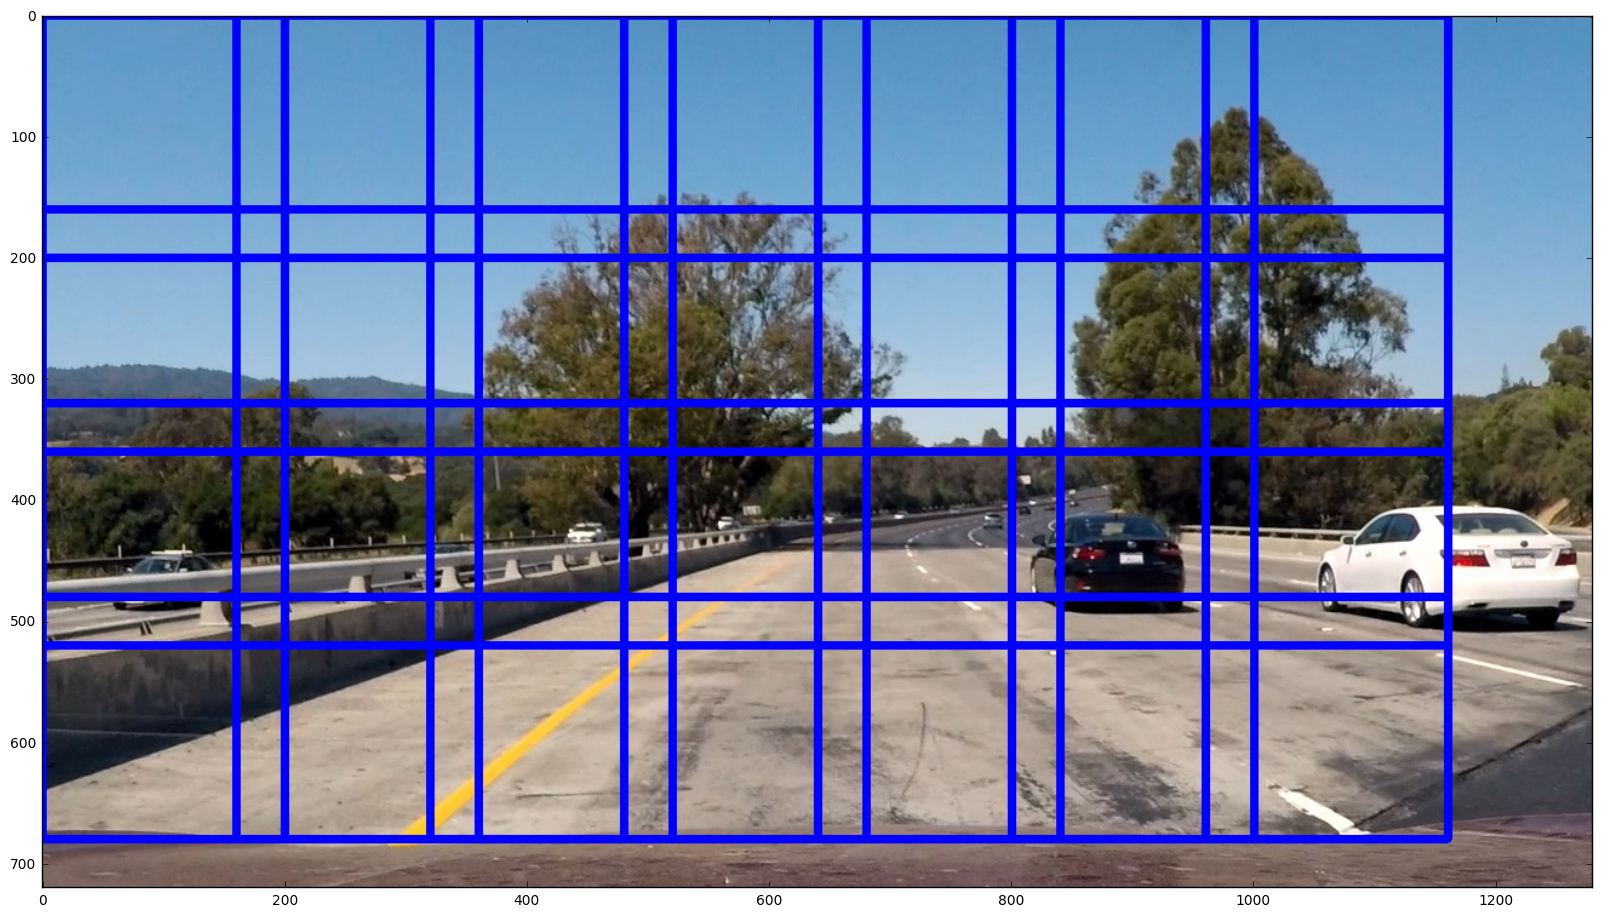

In [4]:
w_list = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[0, 720], xy_window=(200,200), xy_overlap=(0.2, 0.2))
result = draw_boxes(image, w_list)

plt.figure(figsize=(20,20))
plt.imshow(result)

In [5]:
#Auxiliary functions

from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



(720, 1280, 3)
(256, 1280, 3)


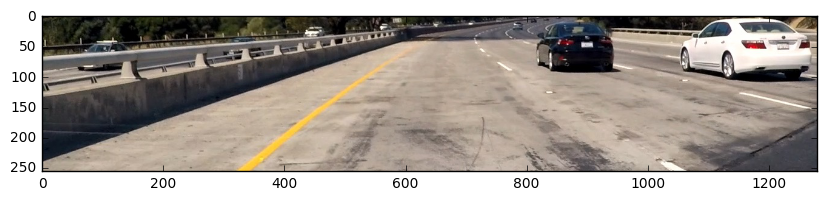

In [6]:
img = mpimg.imread('test1.jpg')
#draw_img = np.copy(img)
#img = img.astype(np.float32)/255

ystart = 400
ystop = 656
img_tosearch = img[400:656,:,:]
print(img.shape)
print(img_tosearch.shape)

plt.figure(figsize=(10,10))
plt.imshow(img_tosearch)
#img2 = convert_color(img, conv='RGB2YCrCb')
#print(img2.shape)



In [7]:
#HOG SUBSAMPLE
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from sklearn.preprocessing import StandardScaler

#svc = pickle.load( open("saved_svc.p", "rb" ) )
#X_scaler =pickle.load( open( "saved_X_scaler.p", "rb" ) )


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc,  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,showImage =True):
    count =0
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    boxes =[]
    
    img_tosearch = img[ystart:ystop,:,:]
    #print(ystart,ystop)
    #print('img', img.shape)
    #print('img_tosearch', img_tosearch.shape)
    
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
                    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #nblocks_per_window = (window // pix_per_cell)-1 
    nblocks_per_window = (window // pix_per_cell)
    
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            #print(yb ,' ypos ',ypos)
            #print(yb ,' ypos ',ypos+nblocks_per_window)
                            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)   
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)   
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)   
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #print('hog_features.shape',hog_features.shape)

            #X_scaler = StandardScaler().fit(hog_features)
            test_features = X_scaler.transform(hog_features).reshape(1, -1)   

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                c1 =  np.random.randint(0, 255)
                c2 =  np.random.randint(0, 255)
                c3 =  np.random.randint(0, 255)
                count+=1
                if showImage==True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(c1,c2,c3),6)              
                    cv2.putText(draw_img,str( count), (int(xbox_left),int(ytop_draw+ystart)), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255), 2,  lineType = cv2.LINE_AA)
                else:
                    if count>0:
                        boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    if showImage:
        return draw_img, count
    else:
        return boxes, count
 

In [8]:
#HOG SUBSAMPLE BOX ONLY
# Study of boxes positions
def find_cars_boxOnly(img, ystart, ystop, scale, svc,  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,showImage =True):
    count=0
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    boxes =[]
    
    img_tosearch = img[ystart:ystop,:,:]
    #print(ystart,ystop)
    #print('img', img.shape)
    #print('img_tosearch', img_tosearch.shape)
    
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = np.copy(img_tosearch)  
                    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #nblocks_per_window = (window // pix_per_cell)-1 
    nblocks_per_window = (window // pix_per_cell)
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    #Plot only the diagonal
    for xb in range(nxsteps):
        yb = xb 
        ypos = yb*cells_per_step
        xpos = xb*cells_per_step

        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell

        xbox_left = np.int(xleft*scale)
        ytop_draw = np.int(ytop*scale)
        win_draw = np.int(window*scale)
        c1 =  np.random.randint(0, 255)
        c2 =  np.random.randint(0, 255)
        c3 =  np.random.randint(0, 255)
        count+=1

        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(c1,c2,c3),6)              
        cv2.putText(draw_img,str( count), (int(xbox_left),int(ytop_draw+ystart)), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 2,  lineType = cv2.LINE_AA)

        
    #Plot one value to the right
    xb = nxsteps
    yb= 0
    ypos = yb*cells_per_step
    xpos = xb*cells_per_step

    xleft = xpos*pix_per_cell
    ytop = ypos*pix_per_cell

    xbox_left = np.int(xleft*scale)
    ytop_draw = np.int(ytop*scale)
    win_draw = np.int(window*scale)
    c1 =  np.random.randint(0, 255)
    c2 =  np.random.randint(0, 255)
    c3 =  np.random.randint(0, 255)
    count+=1

    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(c1,c2,c3),6)              
    cv2.putText(draw_img,str( count), (int(xbox_left),int(ytop_draw+ystart)), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 2,  lineType = cv2.LINE_AA)


    return draw_img, count
 

In [9]:

svc = pickle.load( open("saved_svc_YCrCb.p", "rb" ) ) #Load svc
X_scaler = pickle.load( open("saved_X_scaler_YCrCb.p", "rb" ) ) #Load svc



49


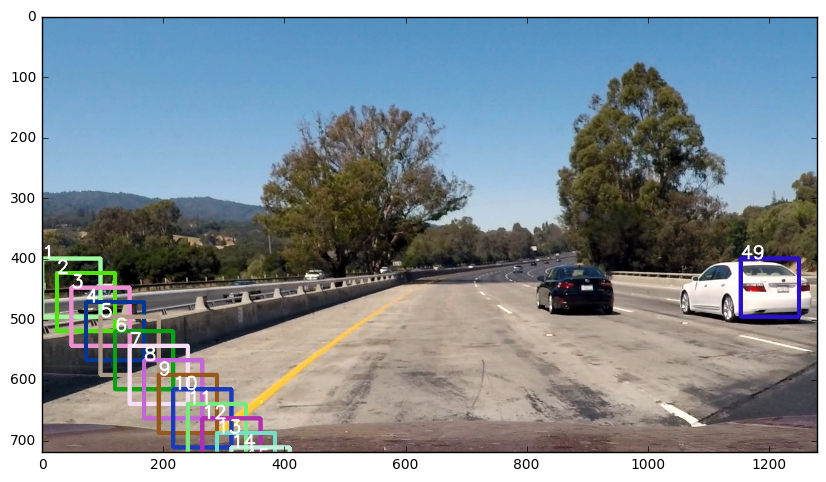

In [10]:
#Test find_cars_boxOnly
ystart = 400
ystop = 656
scale = 1.5


orient = 8 #dist_pickle["orient"]
pix_per_cell = 8 #dist_pickle["pix_per_cell"]
cell_per_block = 1 # dist_pickle["cell_per_block"]
spatial_size = (32, 32) #dist_pickle["spatial_size"]
hist_bins = 32 # dist_pickle["hist_bins"]
cspace = 'YCrCb'
show = True
draw_img, count = find_cars_boxOnly(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,True)


print(count)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [80]:
#Run find_cars in several scales
def find_cars_multiple(img, ystart, ystop, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler):
    #Bom scales = [1.1,1.4, 1.8, 2.2, 2.7, 3.2]
    scales = [1.1,1.4, 1.8, 2.4, 2.9, 3.4]
    
    c=0
    bbox = []           
    for scale in scales:
        c+=1
        #The first half of scales is valid for the upper half of image
        if c<len(scales):
            ystartaux = ystart
            ystopaux = int((ystart+ystop)/2)
        else:
            ystartaux = int((ystart+ystop)/2)
            ystopaux = ystop

        box, count = find_cars(img, ystartaux, ystopaux, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,False)
        if count>0:
            for b in box:
                bbox.append(b)
    return bbox

0


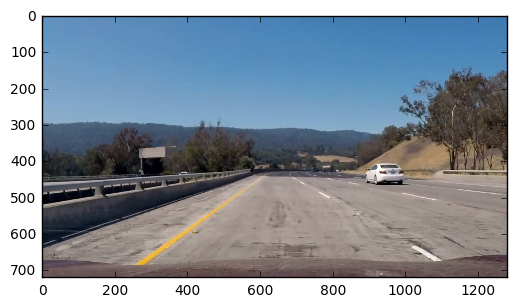

In [114]:
#Test the window classifier in one image

#img = mpimg.imread('test_images/test6.jpg')

ystart = 400
ystop = 656
scale = .8

#img= mpimg.imread('frame06.jpeg')
img = mpimg.imread('frame23.jpeg')
#img = mpimg.imread('frame43.jpeg')
#img = mpimg.imread('frame42.jpeg')


orient = 8 #dist_pickle["orient"]
pix_per_cell = 8 #dist_pickle["pix_per_cell"]
cell_per_block = 1 # dist_pickle["cell_per_block"]
spatial_size = (32, 32) #dist_pickle["spatial_size"]
hist_bins = 32 # dist_pickle["hist_bins"]
cspace = 'YCrCb'
show = True
out_img, count = find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,show)

print(count)
plt.imshow(out_img)


In [55]:
#Test find_cars_multiple

svc = pickle.load( open("saved_svc_YCrCb.p", "rb" ) ) #Load svc
X_scaler = pickle.load( open("saved_X_scaler_YCrCb.p", "rb" ) ) #Load svc

img = mpimg.imread('test1.jpg')

ystart = 400
ystop = 656

orient = 8 #dist_pickle["orient"]
pix_per_cell = 8 #dist_pickle["pix_per_cell"]
cell_per_block = 1 # dist_pickle["cell_per_block"]
spatial_size = (32, 32) #dist_pickle["spatial_size"]
hist_bins = 32 # dist_pickle["hist_bins"]
cspace = 'YCrCb'
show = True
bbox2 = find_cars_multiple(img, ystart, ystop, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler)

#print(bbox2)

for b in bbox2:
    print(b)

((818, 408), (888, 478))
((818, 417), (888, 487))
((836, 426), (906, 496))
((871, 408), (941, 478))
((880, 417), (950, 487))
((1064, 408), (1134, 478))
((1073, 417), (1143, 487))
((1073, 426), (1143, 496))
((1073, 435), (1143, 505))
((67, 411), (156, 500))
((828, 400), (917, 489))
((1052, 411), (1141, 500))
((1064, 400), (1153, 489))
((1064, 411), (1153, 500))


In [56]:
#Test SVC in a single car/noncar image
import glob
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)


X_scaler = pickle.load( open("saved_X_scaler.p", "rb" ) ) #Load svc
#img1 = mpimg.imread('image0038.png')
idx =np.random.randint(0, len(cars))
img1 = mpimg.imread(cars[idx])

#idx =np.random.randint(0, len(notcars))
#img1 = mpimg.imread(notcars[idx])

print('img1.shape',img1.shape)
#plt.imshow(img1)

image= cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)

ch1 = image[:,:,0]
ch2 = image[:,:,1]
ch3 = image[:,:,2]

orient = 8 #dist_pickle["orient"]
pix_per_cell = 8 #dist_pickle["pix_per_cell"]
cell_per_block = 1 # dist_pickle["cell_per_block"]

# Compute individual channel HOG features for the entire image
hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=True).reshape(1, -1)
hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=True).reshape(1, -1)
hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=True).reshape(1, -1)

print('hog1.shape',hog1.shape)

hog_features = np.hstack((hog1, hog2, hog3))
print('hog_features.shape',hog_features.shape)

#X_scaler = StandardScaler().fit(hog_features)
#test_features = X_scaler.transform(hog_features).reshape(1, -1)   
test_features = X_scaler.transform(hog_features)
print('test_features.shape',test_features.shape)

test_prediction = svc.predict(test_features)

print(test_prediction)


img1.shape (64, 64, 3)
hog1.shape (1, 512)
hog_features.shape (1, 1536)
test_features.shape (1, 1536)
[ 1.]


In [57]:
#Test with boxes
b1= ((1,1),(10,32))
b2= ((31,31),(100,132))
b3= ((21,41),(300,332))


boxes =[]
boxes.append(b1)
boxes.append(b2)
boxes.append(b3)

for box in boxes:
    print(box)



((1, 1), (10, 32))
((31, 31), (100, 132))
((21, 41), (300, 332))


[((818, 408), (940, 488)), ((1064, 408), (1152, 499))]
[((818, 408), (940, 488)), ((1064, 408), (1152, 499))]


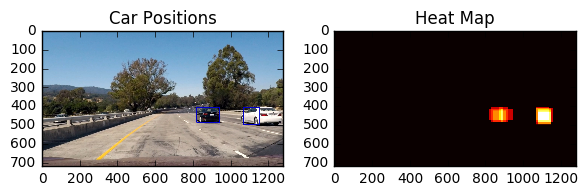

In [58]:
#HEATMAP
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(labels, heatmap,img=None):
    # Iterate through all detected cars
    b_heat=[] #((x1,y1),(x2,y2))

    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        highv = np.sum(heatmap[np.min(nonzeroy):np.max(nonzeroy), np.min(nonzerox):np.max(nonzerox)])
        
        
        # Draw the box on the image
        if not img is None:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,200), 3)
        
        b_heat.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))

    # Return the image
    if not img is None:
        return img,b_heat
    else:
        return b_heat

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = bbox2

# Read in image similar to one shown above 
image = mpimg.imread('test1.jpg')

def heatmap1(image,box_list,threshold=1, showImg = True):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    
    if showImg ==  True:
        draw_img,lbl_heat = draw_labeled_bboxes( labels,heatmap,np.copy(image))
        return draw_img, heatmap,lbl_heat
    else:
        lbl_heat = draw_labeled_bboxes(labels,heatmap)
        return heatmap,lbl_heat


heata,lbl_ha = heatmap1(image,box_list,1,False)

print(lbl_ha)
dimg, heat,lbl_h = heatmap1(image,box_list,1,True)
print(lbl_h)
fig = plt.figure()
plt.subplot(121)
plt.imshow(dimg)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heat, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [59]:
#Playing with lists
a =[]
for i in range(10):
    a.append(0)
print(a)

a[0] =((8,2),(3,2))
a[1] =((4,3),(2,1))
print(a)


finalb =[]

for li in a:
    finalb.append(li)

print(finalb)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[((8, 2), (3, 2)), ((4, 3), (2, 1)), 0, 0, 0, 0, 0, 0, 0, 0]
[((8, 2), (3, 2)), ((4, 3), (2, 1)), 0, 0, 0, 0, 0, 0, 0, 0]


In [117]:
svc = pickle.load( open("saved_svc_YCrCb.p", "rb" ) ) #Load svc
X_scaler = pickle.load( open("saved_X_scaler_YCrCb.p", "rb" ) ) #Load svc
ystart = 400
ystop = 656
orient = 8 #dist_pickle["orient"]
pix_per_cell = 8 #dist_pickle["pix_per_cell"]
cell_per_block = 1 # dist_pickle["cell_per_block"]
spatial_size = (32, 32) #dist_pickle["spatial_size"]
hist_bins = 32 # dist_pickle["hist_bins"]
cspace = 'YCrCb'


nframes = 10
smooth_thres =8
smooth_average=6
bbox_frames =[]
#Inicialization of list
for i in range(nframes):
    bbox_frames.append(0)
counter = 0

    
def process_image(img):
    global counter
    global bbox_frames
    
    counter+=1
    countFrame = counter % nframes
    
    #Find rectangles for one image
    bbox1 = find_cars_multiple(img, ystart, ystop, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler)

    #Find heatmap single image
    thres = smooth_thres
    heat, bboxHeat = heatmap1(img,bbox1, thres, False)
    #print('bboxHeat',bboxHeat)

    #Store the rectangles of the frame
    bbox_frames[countFrame] = bboxHeat
    
    #Sum rectangles of the nframes
    bbox2=[]
    for box in bbox_frames:
        if box!=0:
            for b in box:
                bbox2.append(b)
    #print('bbox2',bbox2)
    
    #Find heatmap of average
    thres = smooth_average
    dimg, heat, bboxHeat2 = heatmap1(img,bbox2, thres, True)
    
    #print('bboxHeat2',bboxHeat2)
    
    
    #Merge heatmap with image
    sizeX = int(256*1.3)
    sizeY = int(144*1.3)
    heat2 = cv2.resize(heat, (sizeX,sizeY))
    #print(np.max(heat2))
    res_img = cv2.resize(img, (sizeX,sizeY))
    res_img_gray = cv2.cvtColor(res_img , cv2.COLOR_RGB2GRAY)
    
    heat3=(heat2/np.max(heat2)*255).astype(int)   
    #print(np.max(heat3))
    #print(np.min(heat3))
    
    
    res_img_gray_R=res_img_gray #np.zeros_like(res_img_gray)
    res_img_gray_R[(heat2>0)] =255
    #img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
    res_img_gray_G =res_img_gray
    res_img_gray_G[(heat2>0)] =0
    res_img_gray_B =res_img_gray
    res_img_gray_B[(heat2>0)] =0
     
    #dimg[0:sizeY,0:sizeX,0]=res_img_gray_R #res_img_gray +heat3 #R
    #dimg[0:sizeY,0:sizeX,1]=res_img_gray_G
    #dimg[0:sizeY,0:sizeX,2]=res_img_gray_B
    
    dimg[0:sizeY,0:sizeX,0]=res_img_gray_R +heat3
    dimg[0:sizeY,0:sizeX,1]=res_img_gray
    dimg[0:sizeY,0:sizeX,2]=res_img_gray
    
    
    cv2.putText(dimg,"Heat Map", (102,25), cv2.FONT_HERSHEY_SIMPLEX, .8,(255,255,255), 1,  lineType = cv2.LINE_AA)
    
    
    #Highest heat value
    #for elem in lbl_heat:
        #cv2.putText(dimg,str(highv), (102,40), cv2.FONT_HERSHEY_SIMPLEX, .6,(255,0,0), 1,  lineType = cv2.LINE_AA)

    #cv2.putText(dimg,str(counter), (108,70), cv2.FONT_HERSHEY_SIMPLEX, 1.1,(255,255,255), 1,  lineType = cv2.LINE_AA)

    return dimg
    

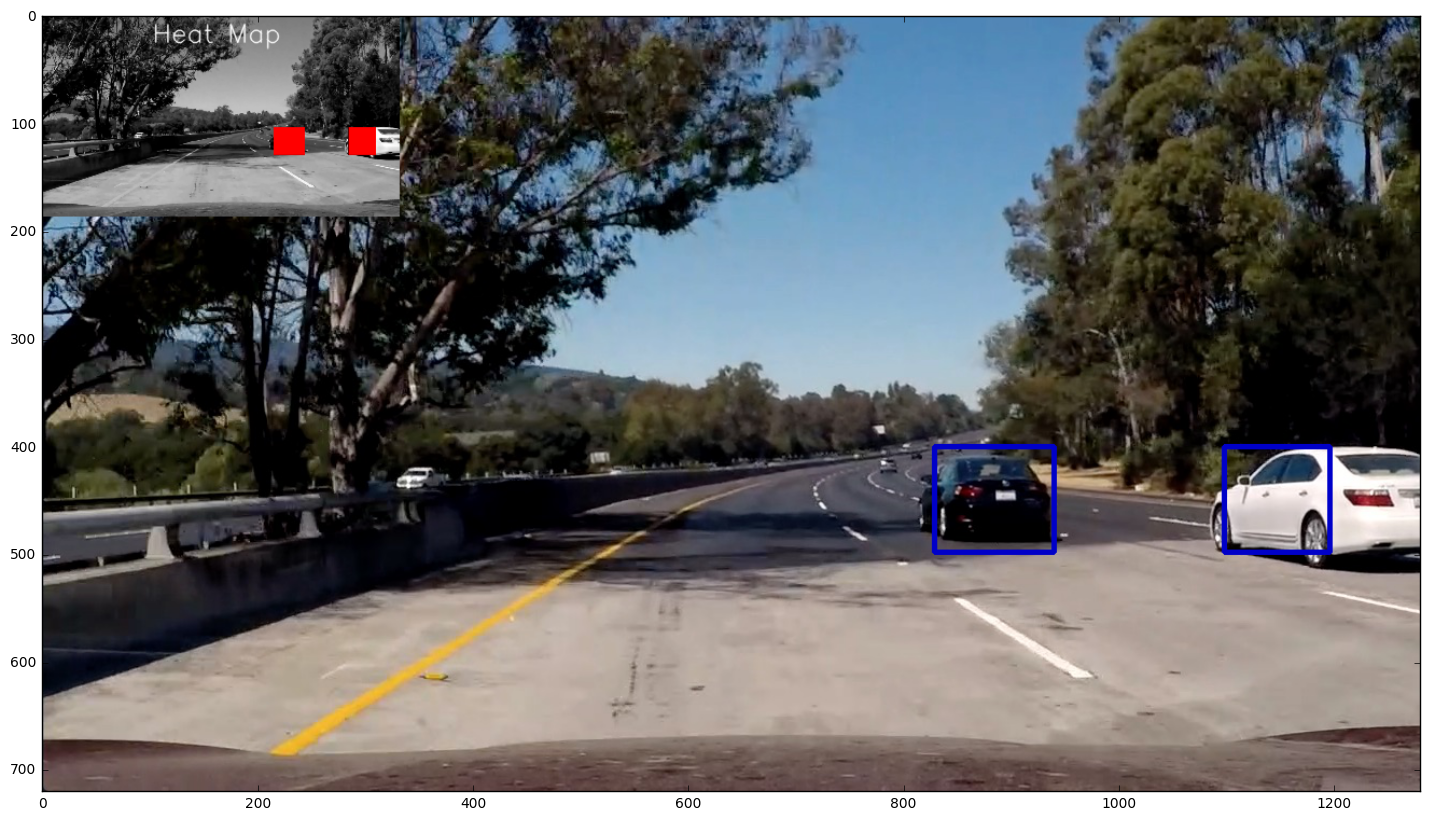

In [149]:

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test5.jpg')

#image = mpimg.imread('frame06.jpeg')
#image = mpimg.imread('frame23.jpeg')
#image = mpimg.imread('frame43.jpeg')
#image = mpimg.imread('frame42.jpeg')

plt.figure(figsize=(25,10))
nframes = 1
smooth_thres =0
smooth_average=0
bbox_frames=[]
#Inicialization of list
for i in range(nframes):
    bbox_frames.append(0)
counter = 0

img2 = process_image(image)
plt.imshow(img2)

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve


In [141]:
#Create video file pipeline
counter=0
nframes = 25
smooth_thres =1
smooth_average=6

bbox_frames=[]
#Inicialization of list
for i in range(nframes):
    bbox_frames.append(0)
counter = 0


output = 'out_project_video.mp4'
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4")#.subclip(40,44)

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)



[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [07:52<00:00,  2.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 8min 48s, sys: 4.81 s, total: 8min 53s
Wall time: 7min 54s


In [142]:
#Save clip 
myclip = clip1.to_ImageClip(t='00:00:06') # frame at t=1 hour.
myclip.save_frame("frame06.jpeg")

In [143]:
#Lane finding
#def hls_color_thresh(img, threshH,threshL, threshS):
def hls_color_thresh(img, threshLow, threshHigh):
    # 1) Convert to HLS color space
    #imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #Hue (0,180) Light (0,255), satur (0,255)

   
    # 3) Return a binary image of threshold result
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    #binary_output[(imgHLS[:,:,0] >= threshH[0]) & (imgHLS[:,:,0] <= threshH[1]) & (imgHLS[:,:,1] >= threshL[0]) & (imgHLS[:,:,1] <= threshL[1])  | ((imgHLS[:,:,2] >= threshS[0]) & (imgHLS[:,:,2] <= threshS[1]))] = 1
    binary_output[(imgHLS[:,:,0] >= threshLow[0]) & (imgHLS[:,:,0] <= threshHigh[0]) & (imgHLS[:,:,1] >= threshLow[1])  & (imgHLS[:,:,1] <= threshHigh[1])  & (imgHLS[:,:,2] >= threshLow[2]) & (imgHLS[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output

#Magnitude threshold
def sobel_x(img, sobel_kernel=3,min_thres = 20, max_thres =100):
    # Apply the following steps to img
    # 1) Convert to grayscale
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the gradient in x and y separately
    #Channels L and S from HLS
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # 5) Create a binary mask where mag thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    # 6) Return this mask as your binary_output image
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1


    # 6) Return this mask as your binary_output image
    return binary_output


#Direction threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

#Both Magnitude and direction threshold
def mag_dir_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0,np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    #Calc angle
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ] = 1


    # 6) Return this mask as your binary_output image
    return binary_output


def fitlines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit,out_img



def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated


#Draw line and return image

def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    #print(left_fitx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    #print(np.int_(pts))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255,215, 0))

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    
    #print("undist", undist.shape)
    #print("newwarp", newwarp.shape)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #result = cv2.addWeighted(undist, 0, newwarp, 1, 0)
    return(result, color_warp)


def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)
        

#Function to process the image
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   



def process_image_lane(image):
    #1. Camera correction
    #Calibration arrays pre-calculated
    #img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    global counter
    
    #2.Magnitude Threshold
    #Threshold color    
    yellow_low = np.array([0,100,100])
    yellow_high = np.array([50,255,255])
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    imgThres_yellow = hls_color_thresh(image,yellow_low,yellow_high)
    imgThres_white = hls_color_thresh(image,white_low,white_high)
    imgThr_sobelx = sobel_x(image,9,80,220) #Sobel x

    img_mag_thr =np.zeros_like(imgThres_yellow)
    #imgThresColor[(imgThres_yellow==1) | (imgThres_white==1)] =1
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    #3. Birds-eye
    #Perspective array pre-calculated
    img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    #4. Detect lanes and return fit curves
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped)
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)
    
    
    #Project video (2.8, 3.5)
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, 0, .55)
    #Challenge video (2.4,3.1)
    #status_sanity, d0, d1, d2 =sanity_check(left_fit, right_fit, 2.4,3.1)
    
    #print(left_fit)
    #print(right_fit)
    
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        
    #left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_merge, img_birds = drawLine(image, binary_warped,left_fit, right_fit)

    
    
    #return img_out, binary_warped, left_curv, right_curv, left_fit, right_fit   
    return img_merge 
    
        


In [146]:

src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M_persp = cv2.getPerspectiveTransform(src, dst)
Minv_persp = cv2.getPerspectiveTransform(dst, src)


In [148]:
output = 'lane_project_video_partial.mp4'

clip2 = VideoFileClip("out_project_video.mp4").subclip(8,15)

out_clip = clip2.fl_image(process_image_lane) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)



[MoviePy] >>>> Building video lane_project_video_partial.mp4
[MoviePy] Writing video lane_project_video_partial.mp4


 99%|█████████▉| 175/176 [00:26<00:00,  6.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_project_video_partial.mp4 

CPU times: user 42.5 s, sys: 688 ms, total: 43.1 s
Wall time: 27.6 s
